In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
from tqdm import tqdm

from torchsummary import summary
from matplotlib import pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
bs = 100
# MNIST Dataset
train_dataset = torchvision.datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)


In [4]:
# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [5]:
class UnFlatten(nn.Module):
    def forward(self, input, size=576):
        return input.view(input.size(0), size, 1, 1)
    
# class VariationalAutoEncoderCNN(nn.Module):
#     def __init__(self, z_dim, h_dim=576):
#         super().__init__()
#         # encoder
#         self.encoder = nn.Sequential(
#             nn.Conv2d(3, 64, kernel_size=3),
#             nn.MaxPool2d(kernel_size=2),
#             nn.Conv2d(64, 16, kernel_size=3),
#             nn.MaxPool2d(kernel_size=2),
#             nn.Flatten()
#         )
        
#         self.fc1 = nn.Linear(h_dim, 256)
#         self.fc2 = nn.Linear(256,z_dim)
#         self.fc3 = nn.Linear(256, z_dim)
#         self.fc4 = nn.Linear(z_dim, 256)
#         self.fc5 = nn.Linear(256,h_dim)
        
#         self.decoder = nn.Sequential(
#             UnFlatten(),
#             nn.ConvTranspose2d(h_dim, 16, kernel_size=3, stride=2),
#             nn.ReLU(),
#             nn.ConvTranspose2d(16, 32, kernel_size=3, stride=2),
#             nn.ReLU(),
#             nn.ConvTranspose2d(32, 64, kernel_size=3, stride=2),
#             nn.ReLU(),
#             nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2),
#         )

#     def encode(self, x):
#         h = self.encoder(x)
#         h=self.fc1(h)
#         mu, sigma = self.fc2(h), self.fc3(h)
#         return mu, sigma

#     def decode(self, z):
#         z = self.fc4(z)

#         z = self.fc5(z)
#         z = self.decoder(z)
#         return z

#     def forward(self, x):
#         mu, sigma = self.encode(x)

#         # Sample from latent distribution from encoder
#         epsilon = torch.randn_like(sigma)
#         z_reparametrized = mu + sigma*epsilon

#         x = self.decode(z_reparametrized)
#         return x, mu, sigma

In [6]:
class VariationalAutoEncoderMLP(nn.Module):
    def __init__(self,z_dim):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256,z_dim)
        self.fc3 = nn.Linear(256, z_dim)
        self.fc4 = nn.Linear(z_dim, 256)
        self.fc5 = nn.Linear(256,784)
        
        
    def encode(self,x):
        x=self.fc1(x)
        return self.fc2(x),self.fc3(x)
    def decode(self,x):
        x = self.fc4(x)
        x = self.fc5(x)
        return F.sigmoid(x)
    def forward(self, x):
        mu, log_sigma = self.encode(x)
        sigma = torch.exp(log_sigma*0.5)
        epsilon = torch.randn_like(sigma)
        z_reparametrized = mu + sigma*epsilon

        x = self.decode(z_reparametrized)
        return x, mu, sigma

In [7]:
# Configuration
INPUT_DIM = 784
NUM_EPOCHS = 50
BATCH_SIZE = 64
LR_RATE = 4e-4

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.detach().numpy()
    t = np.transpose(npimg, (1, 2, 0))
    plt.imshow(t)
    plt.show()

In [10]:
def train(num_epochs, model, optimizer):
    # Start training
    for epoch in range(num_epochs):
        for batch_idx, (x, _) in enumerate(train_loader):
        
            # Forward pass
            # print(x[0][0])
            # imshow(torchvision.utils.make_grid(x[1]))
            x=x[:,0,:,:].view(-1,784).to(device)
            x_reconst, mu, log_sigma = model(x)
            sigma = torch.exp(log_sigma)
            # loss, formulas from https://www.youtube.com/watch?v=igP03FXZqgo&t=2182s
            reconst_loss = F.binary_cross_entropy(x_reconst, x.view(-1, 784), reduction='sum')    #First part of ELBO, reconstruction loss, measures how good is reconstructed image
            kl_div = - torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2)) #Second part of ELBO, measure difference between distribution of latent space and normal distribution

            # Backprop and optimize
            loss = reconst_loss + kl_div
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch%4==0:
            print(loss.item())
# summary(model,(3,32,32))
# Run training
model=VariationalAutoEncoderMLP(z_dim=16).to(device)
train(
    NUM_EPOCHS,
    model,
    torch.optim.Adam(model.parameters(), lr=LR_RATE)
)

12596.353515625
10272.1337890625
9770.2138671875
10231.0283203125
10397.974609375
10244.765625
9362.0966796875
9908.1357421875
10182.73046875
10014.92578125
9846.6884765625
10458.9921875
9696.26953125


0it [00:00, ?it/s]

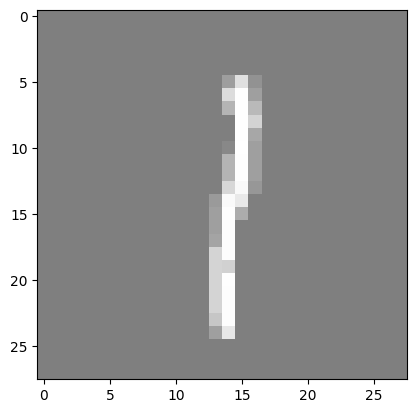

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [ ]:
loop = tqdm(enumerate(train_loader))
def inference(digit, num_examples=1):
    """
    Generates (num_examples) of a particular digit.
    Specifically we extract an example of each digit,
    then after we have the mu, sigma representation for
    each digit we can sample from that.

    After we sample we can run the decoder part of the VAE
    and generate examples.
    """
    from_original = []
    images =[]
    idx = 0
    for x, y in train_loader:
        idx+=1
        images.append(x)
        if idx==3:
            break
    encodings_digit = []
    for d in images:
        with torch.no_grad():
            imshow(torchvision.utils.make_grid(d[1]))
            # mu, sigma = model.encode(images[d].view(-1,3,32,32))
            mu, log_sigma = model.encode(d[1].view(-1,784))
            sigma = torch.exp(log_sigma)
            epsilon = torch.randn_like(torch.exp(sigma))
            z_reparametrized = mu + sigma*epsilon
            x_reconst = model.decode(z_reparametrized)
            x_reconst = x_reconst.view(-1,28,28)
            from_original.append(x_reconst)
            imshow(torchvision.utils.make_grid(x_reconst))
        encodings_digit.append((mu, sigma))
        # save_image(out, f"generated_{digit}_ex{example}.png")
    
    sigma = torch.rand(16)*2-1
    sigma = sigma.view(-1,16)
    mu = torch.normal(0,1,size=(1,16))
    epsilon = torch.randn_like(sigma)
    z_reparametrized = mu
    x_reconst = model.decode(z_reparametrized)
    x_reconst = x_reconst.view(-1,28,28)
    imshow(torchvision.utils.make_grid(x_reconst))

inference(4,num_examples = 5)

